In [0]:
%cd 'drive/My Drive/2516Project'
!ls

/content/drive/My Drive/2516Project
data  elmo  glove  result  saved_models  saved_models_cnn


In [0]:
# !pip install allennlp

# Setting

In [0]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('vader_lexicon')

import ast
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Average, Dropout
from tensorflow.keras.layers import Concatenate, Dropout, Conv1D, MaxPooling1D, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from argparse import ArgumentParser



/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [0]:
NGRAM_CUTOFF = 12
SEED = 42
MAX_LENGTH = 200
EMBED_SIZE = 1024
CORPUS_PATH = 'data/train.tsv'
EMBED_PATH = 'data/elmo.tsv'

# N-grams

In [0]:
def df_to_corpus(df):
    corpus = []
    for i in range(len(df)):
        corpus.append(df['title'][i] + ' ' + df['content'][i])
    re_split = re.compile('^<splt>$')
    re_num_simple = re.compile('^[-$]?[0-9.,]+([eE^][0-9]+)?(th)?$')
    for i in range(len(corpus)):
        curr_article = corpus[i].split(' ')
        new_article = [re_num_simple.subn("<num>", token)[0] for token in curr_article]
        corpus[i] = ' '.join(new_article)
    for i in range(len(corpus)):
        curr_article = corpus[i].split(' ')
        new_article = [re_split.subn(" ", token)[0] for token in curr_article]
        corpus[i] = ' '.join(new_article)
    return corpus

def corpus_vectorizition(corpus, cutoff, ngram_range=[1, 1]):
    stop_words = set(stopwords.words('english'))
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words)
    vectors = vectorizer.fit_transform(corpus).toarray()

    vectors_sum = vectors.sum(axis=0)
    for i in list(vectorizer.vocabulary_.items()):
        if vectors_sum[i[1]] < cutoff:
            del vectorizer.vocabulary_[i[0]]

    for i, key in enumerate(list(vectorizer.vocabulary_.keys())):
        vectorizer.vocabulary_[key] = i

    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words, vocabulary=vectorizer.vocabulary_)
    X = vectorizer.fit_transform(corpus).toarray()

    return X

In [0]:
df = pd.read_csv(CORPUS_PATH, sep='\t', header=None)
df.rename(columns={0: 'id', 1: 'hyperpartisan', 4: 'content', 5: 'title'}, inplace=True)
corpus = df_to_corpus(df)
X = corpus_vectorizition(corpus, NGRAM_CUTOFF, ngram_range=[1, 2]) 
y = np.array(df['hyperpartisan'])
X.shape 

(645, 4791)

In [0]:
svm = SVC(gamma='auto', kernel='linear', random_state=SEED)
rf = RandomForestClassifier(n_estimators=150, random_state=SEED)
lr = LogisticRegression(max_iter=300, random_state=SEED)
xgb = XGBClassifier(n_estimators=150, random_state=SEED)
eclf1 = VotingClassifier(estimators=[ ('rf', rf), ('lr', lr), ('xgb', xgb)], voting='hard')

svm_accuracy_list = []
rf_accuracy_list = []
lr_accuracy_list = []
xgb_accuracy_list = []
eclf1_accuracy_list = []


i = 0
for train, val in kfold.split(X, y):
    i += 1

    X_train, y_train, X_val, y_val = X[train], y[train], X[val], y[val]

    svm_clf = svm.fit(X_train, y_train)
    svm_preds = svm_clf.predict(X_val)
    svm_accuracy_list.append(np.mean(svm_preds == y_val))
    
    rf_clf = rf.fit(X_train, y_train)
    rf_preds = rf_clf.predict(X_val)
    rf_accuracy_list.append(np.mean(rf_preds == y_val))
    
    lr_clf = lr.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_val)
    lr_accuracy_list.append(np.mean(lr_preds == y_val))

    xgb_clf = xgb.fit(X_train, y_train)
    xgb_preds = xgb_clf.predict(X_val)
    xgb_accuracy_list.append(np.mean(xgb_preds == y_val))

    eclf1_clf = eclf1.fit(X_train, y_train)
    eclf1_preds = eclf1.predict(X_val)
    eclf1_accuracy_list.append(np.mean(eclf1_preds == y_val))

svm_accuracy = np.mean(svm_accuracy_list)
rf_accuracy = np.mean(rf_accuracy_list)
lr_accuracy = np.mean(lr_accuracy_list)
xgb_accuracy = np.mean(xgb_accuracy_list)
eclf1_accuracy = np.mean(eclf1_accuracy_list)

print('SVM accuracy', svm_accuracy)
print('Random Forest accuracy', rf_accuracy)
print('Logistic Regression accuracy', lr_accuracy)
print('XGBoost accuracy', xgb_accuracy)
print('Ensemble accuracy', eclf1_accuracy)

SVM accuracy 0.7380288461538462
Random Forest accuracy 0.7533894230769231
Logistic Regression accuracy 0.7535336538461539
XGBoost accuracy 0.7752163461538462
Ensemble accuracy 0.7689663461538461


# Sentiment Analysis

In [0]:
df = pd.read_csv(CORPUS_PATH, sep='\t', header=None)
df.rename(columns={0: 'id', 1: 'hyperpartisan', 4: 'content', 5: 'title'}, inplace=True)
corpus = df_to_corpus(df)
sid = SentimentIntensityAnalyzer()
X = []
for article in corpus:
    blob = TextBlob(article)
    scores = sid.polarity_scores(article)
    s = list(scores.values())
    s.extend(list(blob.sentiment))
    X.append(s)
X = np.array(X)
y = np.array(df['hyperpartisan'])

In [0]:
svm = SVC(gamma='auto', kernel='linear', random_state=SEED)
rf = RandomForestClassifier(n_estimators=150, random_state=SEED)
lr = LogisticRegression(max_iter=300, random_state=SEED)
xgb = XGBClassifier(n_estimators=150, random_state=SEED)
eclf1 = VotingClassifier(estimators=[ ('rf', rf), ('lr', lr), ('xgb', xgb)], voting='hard')

svm_accuracy_list = []
rf_accuracy_list = []
lr_accuracy_list = []
xgb_accuracy_list = []
eclf1_accuracy_list = []


i = 0
for train, val in kfold.split(X, y):
    i += 1

    X_train, y_train, X_val, y_val = X[train], y[train], X[val], y[val]

    svm_clf = svm.fit(X_train, y_train)
    svm_preds = svm_clf.predict(X_val)
    svm_accuracy_list.append(np.mean(svm_preds == y_val))
    
    rf_clf = rf.fit(X_train, y_train)
    rf_preds = rf_clf.predict(X_val)
    rf_accuracy_list.append(np.mean(rf_preds == y_val))
    
    lr_clf = lr.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_val)
    lr_accuracy_list.append(np.mean(lr_preds == y_val))

    xgb_clf = xgb.fit(X_train, y_train)
    xgb_preds = xgb_clf.predict(X_val)
    xgb_accuracy_list.append(np.mean(xgb_preds == y_val))

    eclf1_clf = eclf1.fit(X_train, y_train)
    eclf1_preds = eclf1.predict(X_val)
    eclf1_accuracy_list.append(np.mean(eclf1_preds == y_val))

svm_accuracy = np.mean(svm_accuracy_list)
rf_accuracy = np.mean(rf_accuracy_list)
lr_accuracy = np.mean(lr_accuracy_list)
xgb_accuracy = np.mean(xgb_accuracy_list)
eclf1_accuracy = np.mean(eclf1_accuracy_list)

print('SVM accuracy', svm_accuracy)
print('Random Forest accuracy', rf_accuracy)
print('Logistic Regression accuracy', lr_accuracy)
print('XGBoost accuracy', xgb_accuracy)
print('Ensemble accuracy', eclf1_accuracy)

SVM accuracy 0.6310096153846153
Random Forest accuracy 0.6881009615384616
Logistic Regression accuracy 0.6371874999999999
XGBoost accuracy 0.7021153846153846
Ensemble accuracy 0.6974519230769232


# ELMo

In [0]:
def load_pretrained(path, max_length=200):
    X, all_label = [], []
    i = 0
    label_encoder = LabelEncoder()
    with open(path, 'rb') as f:
        for line in f:
            fields = line.decode('utf-8').split('\t')
            label = fields[1]
            embedding_list = ast.literal_eval(fields[4].strip())
            embedding_array = np.array(embedding_list)
            padded_sequences = sequence.pad_sequences([embedding_array], maxlen=max_length, dtype='float32')[0]
            X.append(padded_sequences)
            all_label.append(label)
            i += 1
    Y = label_encoder.fit_transform(all_label)

    return np.array(X), np.array(Y)

In [0]:
def train_network(model_name): 
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
    cv_scores = []
    i = 0
    for train, val in kfold.split(X_data, y_data):
        i += 1
        print("current fold is : {}".format(i))
        model = model_name(max_length=MAX_LENGTH, embed_size=EMBED_SIZE)
        history = model.fit(X_data[train], y_data[train], batch_size=32, verbose=0, epochs=30,
                validation_data=(X_data[val], y_data[val]))
        cv_scores.append(history.history['val_acc'][-1])
        K.clear_session()

    print("Final score: {:.4} (+/- {:.4})".format(np.mean(cv_scores), np.std(cv_scores)))

In [0]:
X_data, y_data  = load_pretrained(path=EMBED_PATH, max_length=MAX_LENGTH)
X_data.shape 

(645, 200, 1024)

# Feedforward Networks

In [0]:
def feedforward(max_length, embed_size):
    inputs = Input(shape=(max_length, embed_size), dtype='float32')
    drop1 = Dropout(rate=0)(inputs)
    dense1 = Dense(300, activation='relu')(drop1)
    bn_1 = BatchNormalization(momentum=0.7)(dense1)
    drop2 = Dropout(rate=0.2)(bn_1)
    dense2 = Dense(100, activation='relu')(drop2)
    bn_2 = BatchNormalization(momentum=0.7)(dense2)
    drop3 = Dropout(rate=0.2)(bn_2)
    flatten = Flatten()(drop3)
    output = Dense(1, activation='sigmoid')(flatten)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')
    return model

In [0]:
train_network(feedforward)


current fold is : 1 
current fold is : 2 
current fold is : 3 
current fold is : 4 
current fold is : 5 
current fold is : 6 
current fold is : 7 
current fold is : 8 
current fold is : 9 
current fold is : 10 
Final score: 0.8280% (+/- 0.0344%)


# LSTM

In [0]:
def LSTM_model(max_length, embed_size):
    inputs = Input(shape=(max_length, embed_size), dtype='float32')
    lstm1 = LSTM(300, return_sequences=True)(inputs)
    drop1 = Dropout(0.1)(lstm1)
    lstm2 = LSTM(300, return_sequences=True)(drop1)
    drop2 = Dropout(0.1)(lstm2)
    flatten = Flatten()(drop2)
    output = Dense(1, activation='sigmoid')(flatten)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')
    return model

In [0]:
train_network(LSTM_model)

current fold is : 1 
Current Fold Score: 0.7692
current fold is : 2 
Current Fold Score: 0.8000
current fold is : 3 
Current Fold Score: 0.8154
current fold is : 4 
Current Fold Score: 0.8462
current fold is : 5 
Current Fold Score: 0.8308
current fold is : 6 
Current Fold Score: 0.8281
current fold is : 7 
Current Fold Score: 0.9062
current fold is : 8 
Current Fold Score: 0.7500
current fold is : 9 
Current Fold Score: 0.8906
current fold is : 10 
Current Fold Score: 0.7812
Final score: 0.8218% (+/- 0.0476%)


In [0]:
def BiLSTM_model(max_length, embed_size):
    inputs = Input(shape=(max_length, embed_size), dtype='float32')
    lstm1 = Bidirectional(LSTM(300, return_sequences=True))(inputs)
    drop1 = Dropout(0.1)(lstm1)
    lstm2 = Bidirectional(LSTM(300, return_sequences=True))(drop1)
    drop2 = Dropout(0.1)(lstm2)
    flatten = Flatten()(drop2)
    output = Dense(1, activation='sigmoid')(flatten)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')
    return model

In [0]:
train_network(BiLSTM_model)

current fold is : 1 
Current Fold Score: 0.8154
current fold is : 2 
Current Fold Score: 0.7846
current fold is : 3 
Current Fold Score: 0.8769
current fold is : 4 
Current Fold Score: 0.8615
current fold is : 5 
Current Fold Score: 0.8308
current fold is : 6 
Current Fold Score: 0.8125
current fold is : 7 
Current Fold Score: 0.9219
current fold is : 8 
Current Fold Score: 0.8281
current fold is : 9 
Current Fold Score: 0.8281
current fold is : 10 
Current Fold Score: 0.8125
Final score: 0.8372% (+/- 0.0374%)


# CNN

In [0]:
def CNN_model(max_length, embed_size):
    filter_sizes = [2, 3, 4, 5, 6]
    num_filters = 128
    inputs = Input(shape=(max_length, embed_size), dtype='float32')

    conv0 = Conv1D(num_filters, kernel_size=(filter_sizes[0]))(inputs)
    conv1 = Conv1D(num_filters, kernel_size=(filter_sizes[1]))(inputs)
    conv2 = Conv1D(num_filters, kernel_size=(filter_sizes[2]))(inputs)
    conv3 = Conv1D(num_filters, kernel_size=(filter_sizes[3]))(inputs)
    conv4 = Conv1D(num_filters, kernel_size=(filter_sizes[4]))(inputs)

    act0 = Activation('relu')(conv0)
    act1 = Activation('relu')(conv1)
    act2 = Activation('relu')(conv2)
    act3 = Activation('relu')(conv3)
    act4 = Activation('relu')(conv4)

    bn0 = BatchNormalization(momentum=0.7)(act0)
    bn1 = BatchNormalization(momentum=0.7)(act1)
    bn2 = BatchNormalization(momentum=0.7)(act2)
    bn3 = BatchNormalization(momentum=0.7)(act3)
    bn4 = BatchNormalization(momentum=0.7)(act4)

    maxpool0 = MaxPooling1D(pool_size=(max_length - filter_sizes[0]))(bn0)
    maxpool1 = MaxPooling1D(pool_size=(max_length - filter_sizes[1]))(bn1)
    maxpool2 = MaxPooling1D(pool_size=(max_length - filter_sizes[2]))(bn2)
    maxpool3 = MaxPooling1D(pool_size=(max_length - filter_sizes[3]))(bn3)
    maxpool4 = MaxPooling1D(pool_size=(max_length - filter_sizes[4]))(bn4)

    concatenated_tensor = Concatenate()([maxpool0, maxpool1, 
                                         maxpool2, maxpool3, maxpool4])
    flatten = Flatten()(concatenated_tensor)
    output = Dense(units=1, activation='sigmoid')(flatten)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')
    return model

In [0]:
train_network(CNN_model)

current fold is : 1 
current fold is : 2 
current fold is : 3 
current fold is : 4 
current fold is : 5 
current fold is : 6 
current fold is : 7 
current fold is : 8 
current fold is : 9 
current fold is : 10 
Final score: 0.8095 (+/- 0.04821)


# Overfitting Investigation

In [0]:
def pipeline(X, y):
    def sigmoid_to_binary(preds):
        result = []
        for p in preds:
            if p > 0.5:
                result.append(1)
            else:
                result.append(0)
        return result 

    cv_scores = []
    models = []
    for train, val in kfold.split(X, y):
        model = feedforward(max_length=EMBED_SIZE, embed_size=EMBED_SIZE)
        history = model.fit(X[train], y[train], batch_size=32, verbose=0, epochs=30,
                validation_data=(X[val], y[val])) 
        models.append(model)
        cv_scores.append(history.history['val_acc'][-1])
        K.clear_session()

    print('Training size: {}'.format(len(X)))
    print("Final score: {:.4} (+/- {:.4})".format(np.mean(cv_scores), np.std(cv_scores)))
    top3_indicies = sorted( [i for (i, x) in enumerate(cv_scores)], reverse=True)[:3]
    model1, model2, model3 = np.array(models)[top3_indicies]

    preds1, preds2, preds3 = model1.predict(X_test), model2.predict(X_test), model3.predict(X_test)
    preds1, preds2, preds3 = sigmoid_to_binary(preds1), sigmoid_to_binary(preds2), sigmoid_to_binary(preds3)
    acc1, acc2, acc3 = np.mean(preds1 == y_test), np.mean(preds2 == y_test), np.mean(preds3 == y_test)

    print('Test score of the best 3 models is {:.4}', np.mean([acc1, acc2, acc3]))



In [0]:
permutation = np.random.permutation(645)
X_new, y_new = X_data[permutation], y_data[permutation]
num_test = 80
X_test, y_test = X_new[:num_test], y_new[:num_test]
X50, y50 = X_new[num_test: num_test+50], y_new[num_test: num_test+50]
X100, y100 = X_new[num_test: num_test+100], y_new[num_test: num_test+100]
X200, y200 = X_new[num_test: num_test+200], y_new[num_test: num_test+200]
X350, y350 = X_new[num_test: num_test+350], y_new[num_test: num_test+350]
X565, y565 = X_new[num_test: num_test+565], y_new[num_test: num_test+565]

In [0]:
pipeline(X50, y50)

Training size: 50
Final score: 0.6800% (+/- 0.1327%)
Test score of the best 3 models is {:.4} 0.7333333333333334


In [0]:
pipeline(X100, y100)

Training size: 100
Final score: 0.7600% (+/- 0.1114%)
Test score of the best 3 models is {:.4} 0.7416666666666667


In [0]:
pipeline(X200, y200)

Training size: 200
Final score: 0.7600% (+/- 0.1068%)
Test score of the best 3 models is {:.4} 0.8083333333333332


In [0]:
pipeline(X350, y350)

Training size: 350
Final score: 0.8029% (+/- 0.0645%)
Test score of the best 3 models is {:.4} 0.8083333333333332


In [0]:
pipeline(X565, y565)

Training size: 565
Final score: 0.8106% (+/- 0.0441%)
Test score of the best 3 models is {:.4} 0.8333333333333334


In [0]:
num_training = [50, 100, 200, 350, 565]
val_scores = [0.6800, 0.7600, 0.7600, 0.8029, 0.8106]
test_scores = [0.7333, 0.7416, 0.8083, 0.8083, 0.8333]

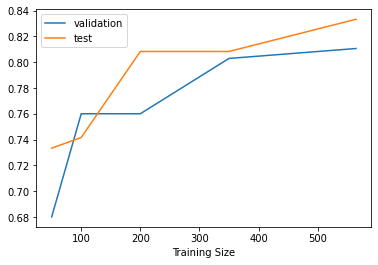

In [0]:
plt.plot(num_training, val_scores, label='validation')
plt.plot(num_training, test_scores, label='test')
plt.xlabel("Training Size")
plt.legend()
plt.show()